## Scikit Image, and DIPY for neuroimaging

In [4]:
import skimage as ski
import skimage
from scipy.signal import convolve2d

Check this gallery:

https://scikit-image.org/docs/stable/auto_examples/index.html

Important parts include: Image registration, Geometrical transformations, Segmentation

### Convolution Filters

In [5]:
import os
os.chdir(r'C:\Users\ASUS\Data science in neuroimaging\ndslib-main')
from ndslib.viz import imshow_with_annot
import numpy as np

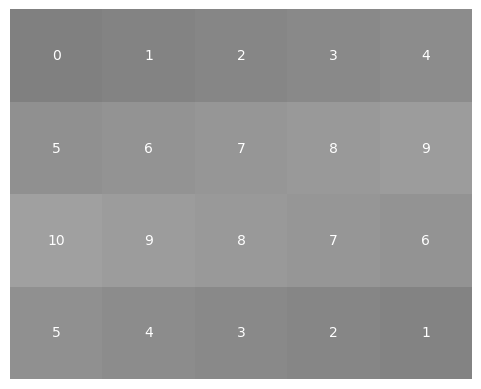

In [20]:
small_image = np.concatenate([np.arange(10), np.arange(10, 0, -1)]).reshape((4, 5))
imshow_with_annot(small_image)

In [22]:
small_image

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10,  9,  8,  7,  6],
       [ 5,  4,  3,  2,  1]])

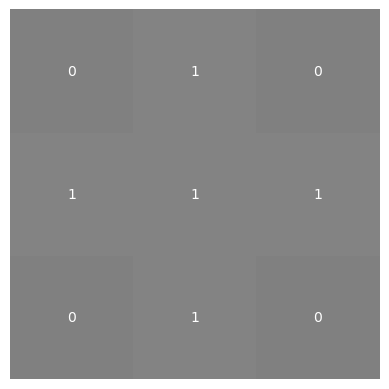

In [24]:
small_result = np.zeros(small_image.shape)
small_kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
imshow_with_annot(small_kernel)

Before we can get to convolving the kernel and the image (“convolving” is the verb
form of“convolution”),we have to dealwith the fact that not all of the pixels have thesame
number of neighborssurrounding them.This is becausesome of the pixels areright on the
edge of the image. One way to deal with that is to pad the image all around with zeros 14.5:

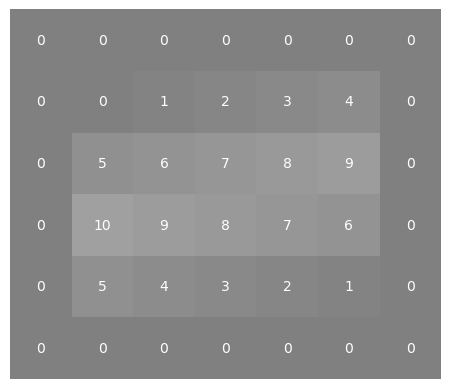

In [29]:
padded_small_image = np.pad(small_image, 1)
imshow_with_annot(padded_small_image)

In [41]:
convolution_full = convolve2d(padded_small_image, small_kernel, mode='full')

In [35]:
padded_small_image.shape

(6, 7)

In [37]:
small_kernel.shape

(3, 3)

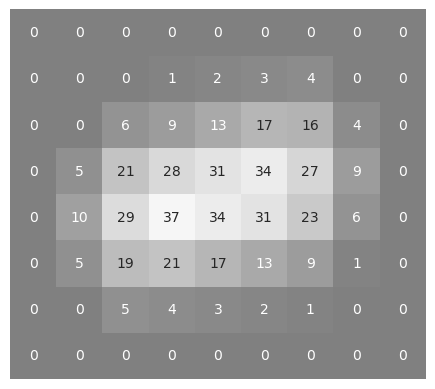

In [43]:
imshow_with_annot(convolution_full)

### Convolution Filters with scikit image

In [54]:
from ndslib.data import load_data
from skimage.filters import gaussian
brain = load_data("bold_volume")

In [50]:
brain.shape

(64, 64, 25)

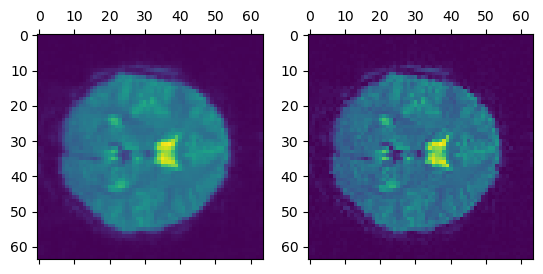

In [60]:
smoothed_brain = gaussian(brain, sigma=0.5)
fig, ax = plt.subplots(1, 2)
ax[0].matshow(smoothed_brain[:, :, 10])
im = ax[1].matshow(brain[:, :, 10])

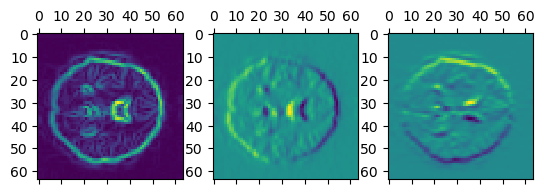

In [69]:
from skimage.filters import sobel, sobel_h, sobel_v
img_bold_10 = smoothed_brain[:, :, 10]
fig, ax = plt.subplots(1, 3)
sobel_collins = sobel(img_bold_10)
ax[0].matshow(sobel_collins)
sobel_v_collins = sobel_v(img_bold_10)
ax[1].matshow(sobel_v_collins)
sobel_h_collins = sobel_h(img_bold_10)
ax[2].matshow(sobel_h_collins)

### Intensity based Segmentation

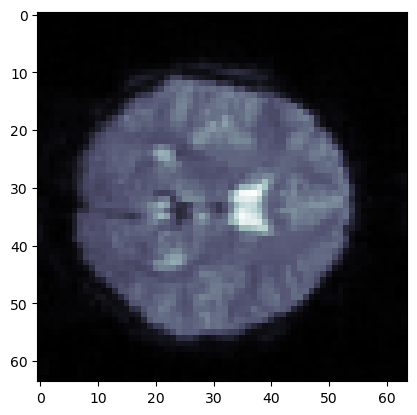

In [72]:
fig, ax = plt.subplots()
im = ax.imshow(img_bold_10, cmap="bone")

(array([2322.,  110.,   93.,  636.,  729.,  145.,   22.,   13.,   13.,
          13.]),
 array([2.81380248e-01, 1.20527492e+02, 2.40773605e+02, 3.61019717e+02,
        4.81265829e+02, 6.01511941e+02, 7.21758053e+02, 8.42004165e+02,
        9.62250278e+02, 1.08249639e+03, 1.20274250e+03]),
 <BarContainer object of 10 artists>)

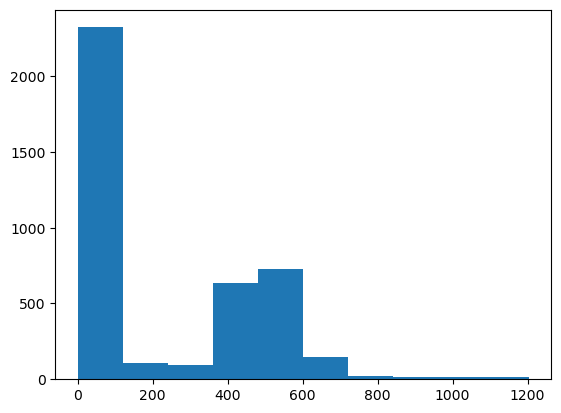

In [78]:
plt.hist(img_bold_10.flat)

In [117]:
idx = img_bold_10 > np.mean(img_bold_10) # we can use the mean of intensity for segmentation
img_bold_10_filt = img_bold_10[idx]

In [91]:
img_bold_10_filt.shape

(1681,)

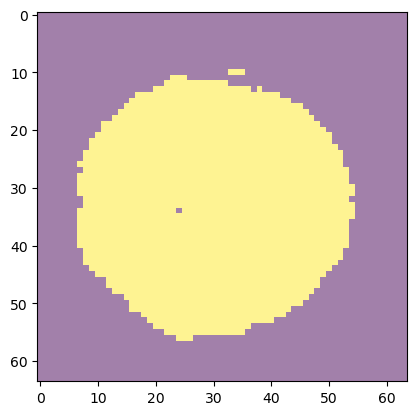

In [115]:
segmentation = np.zeros_like(img_bold_10)
segmentation[img_bold_10 > np.mean(img_bold_10)] = 1

fig, ax = plt.subplots()
#ax.imshow(img_bold_10, cmap="bone")
ax.imshow(segmentation, alpha=0.5)

In [149]:
# we can use otsu method instead
from skimage.filters import threshold_otsu


In [151]:
thre = threshold_multiotsu(image = img_bold_10)

In [153]:
thre

array([260.97119371, 693.10565928])

In [172]:
 np.mean(img_bold_10)

224.25409757726916

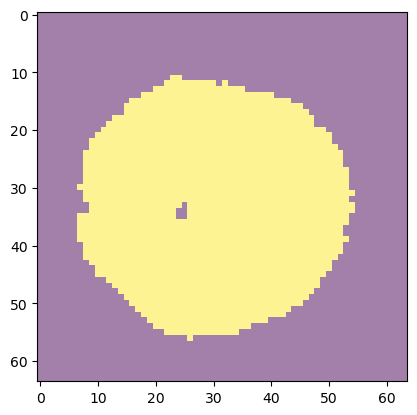

In [169]:
#segmentation = np.zeros_like(img_bold_10)

segmentation = img_bold_10 >= thre[0]
fig, ax = plt.subplots()
#ax.imshow(img_bold_10, cmap="bone")
ax.imshow(segmentation, alpha=0.5)

### Edge-Based Segmentation

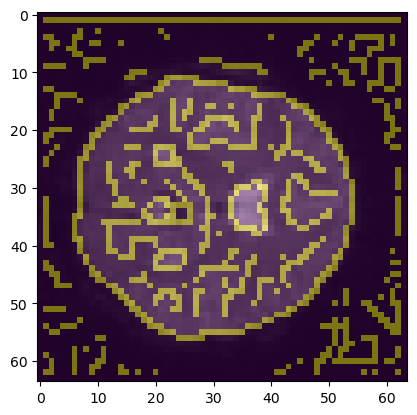

In [180]:
from skimage.feature import canny
edges = canny(img_bold_10)
fig, ax = plt.subplots()
ax.imshow(img_bold_10, cmap="gray")
im = ax.imshow(edges, alpha=0.5)

## Image registration

What do we do if our subject moves between the acquisition ofthe BOLD fMRI data and the T1-weighted data? Or between different volumes of thesame fMRI series. In these cases, image registration methods are used to calculate how weneed to move images toward each other so that they maximally overlap.

In [11]:
import templateflow.api as tflow
import nibabel as nib
from ndslib.data import download_bids_dataset

In [13]:
mni_img = nib.load(tflow.get('MNI152NLin2009cAsym', resolution=1, suffix="T1w", desc=None))
mni_data = mni_img.get_fdata()

100%|█████████████████████████████████████████████████████████████████████████████| 13.7M/13.7M [00:07<00:00, 1.86MB/s]


In [39]:
download_bids_dataset()
t1_img = nib.load("ds001233/sub-17/ses-pre/anat/sub-17_ses-pre_T1w.nii.gz")
img_data = t1_img.get_fdata()

In [49]:
img_data.shape

(256, 256, 176)

In [51]:
mni_data.shape

(193, 229, 193)

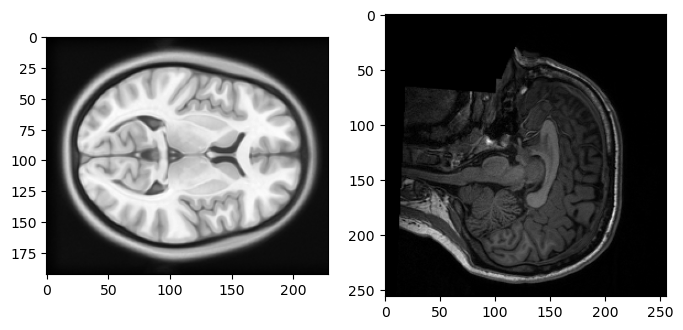

In [47]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(mni_data[:,:,85], cmap="gray")
ax[1].imshow(img_data[:,:,85], cmap="gray")

1. First we will resample the data to have a similar dimension (resample_from_to function)
2. Use affine transformation for image registration (Using AffineTransform3D function)

In [57]:
from nibabel.processing import resample_from_to
t1_resampled = resample_from_to(t1_img, (mni_img.shape, mni_img.affine))
t1_resamp_data = t1_resampled.get_fdata()

In [63]:
t1_resamp_data.shape

(193, 229, 193)

In [65]:
mni_data.shape

(193, 229, 193)

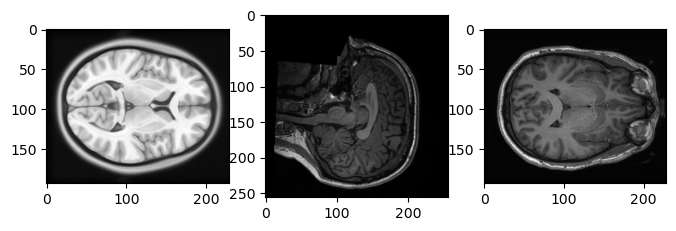

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(mni_data[:,:,85], cmap="gray")
ax[1].imshow(img_data[:,:,85], cmap="gray")
ax[2].imshow(t1_resamp_data[:,:,85], cmap="gray")

In [88]:
from dipy.align.transforms import AffineTransform3D

In [92]:
affreg = AffineRegistration()
affine3d = affreg.optimize(mni_data, t1_resamp_data, AffineTransform3D(), params0=None)
t1_xform = affine3d.transform(t1_resamp_data)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [96]:
t1_xform.shape

(193, 229, 193)

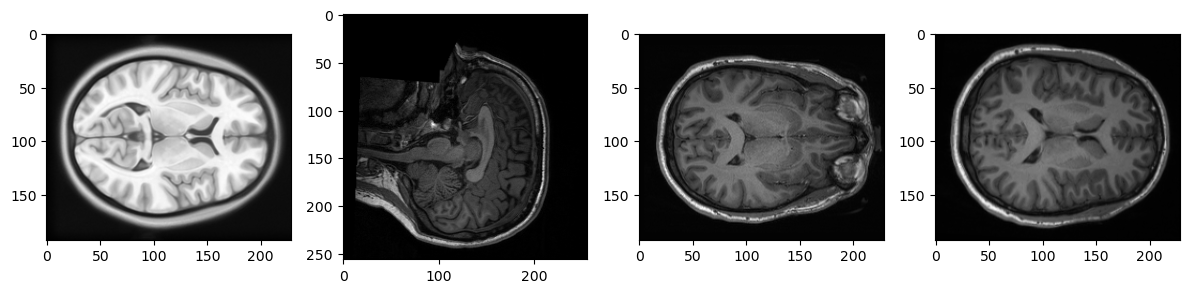

In [122]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
ax = axes.ravel()

ax[0].imshow(mni_data[:,:,85], cmap="gray")
ax[1].imshow(img_data[:,:,85], cmap="gray")
ax[2].imshow(t1_resamp_data[:,:,85], cmap="gray")
ax[3].imshow(t1_xform[:,:,85], cmap="gray")

#stereo = np.zeros((193, 229, 3), dtype=np.uint8) #normalize
#stereo[..., 0] = 255 * mni_data[:, :, 85]/np.max(mni_data)
#stereo[..., 0] = 255 * t1_xform[:, :, 85]/np.max(t1_xform)
#ax[4].imshow(stereo, cmap="gray")
fig.tight_layout()

This is not bad. still ventricles a bit off. What more can we do?

We are going to use the cross-correlation between the images, using the CCMetric object

In [130]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric

In [132]:
metric = CCMetric(3)
sdr = SymmetricDiffeomorphicRegistration(metric)
mapping = sdr.optimize(mni_data, t1_resamp_data, prealign=affine3d.affine)
t1_warped = mapping.transform(t1_resamp_data)

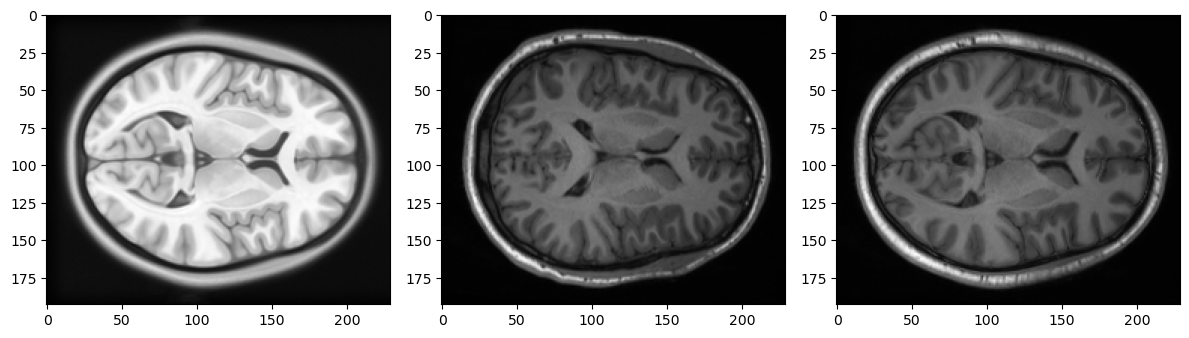

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ax = axes.ravel()

ax[0].imshow(mni_data[:,:,85], cmap="gray")
ax[1].imshow(t1_xform[:,:,85], cmap="gray") # after affine transform
ax[2].imshow(t1_warped[:,:,85], cmap="gray") # after Diffeomorphic Registration

fig.tight_layout()